In [1]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import pymc3 as pm
import theano.tensor as T
import theano

from scipy.stats import mode, chisquare

from sklearn.metrics import confusion_matrix, accuracy_score

import lasagne

import sys, os

In [2]:
def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve
    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)
    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip
    # Check for data in folder, if not download
    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)
    #Load labels
    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data
    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')
    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [3]:
print("Loading data...")
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
# Building a theano.shared variable with a subset of the data to make construction of the model faster.
input_var = theano.shared(X_train.astype(np.float64))
target_var = theano.shared(y_train.astype(np.float64))

Loading data...


In [4]:
def build_ann(initw, initb, input_var, target_var):
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                     input_var=input_var)
    # Add a fully-connected layer of 600 units, using the linear rectifier, and
    # initializing weights with Glorot's scheme (which is the default anyway):
    with pm.Model() as neural_network:
        n_hid1 = 600
        l_hid1 = lasagne.layers.DenseLayer(
            l_in, num_units=n_hid1,
            nonlinearity=lasagne.nonlinearities.tanh,
            b=initw,
            W=initb
        )
        n_hid2 = 600
        # Another 600-unit layer:
        l_hid2 = lasagne.layers.DenseLayer(
            l_hid1, num_units=n_hid2,
            nonlinearity=lasagne.nonlinearities.tanh,
            b=initw,
            W=initb
        )
        # Finally, we'll add the fully-connected output layer, of 10 softmax units:
        l_out = lasagne.layers.DenseLayer(
            l_hid2, num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax,
            b=initw,
            W=initb
        )
        prediction = lasagne.layers.get_output(l_out)
        # 10 discrete output classes -> pymc3 categorical distribution
        out = pm.Categorical('out', 
                            prediction,
                            observed=target_var,
                            total_size=y_train.shape[0])
    return neural_network

In [5]:
class GaussWeights(object):
    def __init__(self):
        self.count = 0
    def __call__(self, shape):
        self.count += 1
        return pm.Normal('w%d' % self.count, mu=0, sd=0.1, 
                         testval=np.random.normal(size=shape).astype(np.float64),
                         shape=shape)

In [6]:
class GaussBiases(object):
    def __init__(self):
        self.count = 0
    def __call__(self, shape):
        self.count += 1
        return pm.Normal('b%d' % self.count, mu=0, sd=3, 
                         testval=np.random.normal(size=shape).astype(np.float64),
                         shape=shape)

In [7]:
minibatch_x = pm.Minibatch(X_train, batch_size=500, dtype='float64')
minibatch_y = pm.Minibatch(y_train, batch_size=500, dtype='float64')

In [8]:
neural_network = build_ann(initw = GaussWeights(), initb = GaussBiases(), input_var = input_var, target_var = target_var)
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(10000, more_replacements={input_var: minibatch_x, target_var:minibatch_y}, method=inference)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 11,534: 100%|██████████| 10000/10000 [33:21<00:00,  5.00it/s]
Finished [100%]: Average Loss = 11,534


In [9]:
trace = approx.sample(draws = 500)
trace = trace[200:]
#pm.summary(trace).to_csv("trace_nuts.csv")

In [10]:
waic = pm.waic(trace, neural_network)
loo = pm.loo(trace, neural_network)

/home/waic-team/.local/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/waic-team/.local/lib/python3.6/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


In [11]:
print("WAIC for FNN network: ", {waic.WAIC})
print("Posterior variances", waic.VARS)
print("LOO for FNN network: ", {loo.LOO})
print("Estimated shape parameters", loo.KS)

WAIC for FNN network:  {10958985.755112128}
Posterior variances [2.51101801e+02 4.57226372e-07 8.33738835e+01 ... 8.20526846e+01
 1.61261232e+02 4.97779846e+01]
LOO for FNN network:  {3667348.736904257}
Estimated shape parameters [11.39273784  7.20822309  9.40342594 ...  8.18160689  7.06251507
  8.01586653]


In [12]:
print(waic.VARS.shape)
count_w = np.sum(waic.VARS > float(0.4))
print("Violations of posterior variances:", count_w)
print(loo.KS.shape)
count_k = np.sum(loo.KS > float(0.7))
print("Violations of estimated shape parameters:", count_k)

(50000,)
Violations of posterior variances: 44894
(50000,)
Violations of estimated shape parameters: 49998


Text(0.5,0,'iteration')

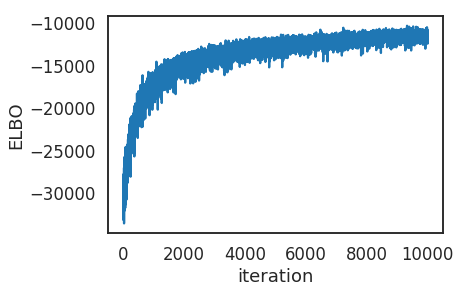

In [13]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration')

In [14]:
with neural_network:
    approx_nuts = pm.fit(10000, more_replacements={input_var: minibatch_x, target_var:minibatch_y})

Average Loss = 11,500: 100%|██████████| 10000/10000 [32:34<00:00,  5.12it/s]
Finished [100%]: Average Loss = 11,496


In [15]:
trace_nuts = approx_nuts.sample(draws = 500)
trace_nuts = trace_nuts[200:]

In [16]:
waic_nuts = pm.waic(trace_nuts, neural_network)
loo_nuts = pm.loo(trace_nuts, neural_network)

/home/waic-team/.local/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/waic-team/.local/lib/python3.6/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


In [17]:
print("WAIC for FNN network with NUTS: ", {waic_nuts.WAIC})
print("Posterior variances", waic_nuts.VARS)
print("LOO for FNN network with NUTS: ", {loo_nuts.LOO})
print("Estimated shape parameters", loo_nuts.KS)

WAIC for FNN network with NUTS:  {11193230.606055643}
Posterior variances [3.09345667e+02 1.90165076e-01 1.82670426e+02 ... 1.39813795e+02
 3.13606612e+02 5.56576295e+01]
LOO for FNN network with NUTS:  {3694855.2824180787}
Estimated shape parameters [12.42345367  8.74077635 12.73222589 ...  8.91997438 13.25141434
 10.04765797]


In [18]:
print(waic_nuts.VARS.shape)
count_w_nuts = np.sum(waic_nuts.VARS > float(0.4))
print("Violations of posterior variances:", count_w_nuts)
print(loo_nuts.KS.shape)
count_k_nuts = np.sum(loo_nuts.KS > float(0.7))
print("Violations of estimated shape parameters:", count_k)

(50000,)
Violations of posterior variances: 45063
(50000,)
Violations of estimated shape parameters: 49998


In [19]:
input_var.set_value(X_test)
target_var.set_value(y_test)


with neural_network:
    ppc = pm.sample_ppc(trace, samples=100)

y_pred = mode(ppc['out'], axis=0).mode[0, :]

print('Accuracy on test data for FNN with ADVI= {}%'.format(accuracy_score(y_test, y_pred) * 100))


with neural_network:
    ppc_nuts = pm.sample_ppc(trace_nuts, samples=100)

y_pred_nuts = mode(ppc_nuts['out'], axis=0).mode[0, :]

print('Accuracy on test data for FNN with NUTS= {}%'.format(accuracy_score(y_test, y_pred_nuts) * 100))

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on test data for FNN with ADVI= 92.13%


100%|██████████| 100/100 [01:37<00:00,  1.03it/s]

Accuracy on test data for FNN with NUTS= 92.11%
